<a href="https://colab.research.google.com/github/25thBaamDice/SerieDeTiempo/blob/main/RNN_EC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

#from keras import initializers
#from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import load_model
#from tensorflow.keras.regularizers import l1, l2
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
%matplotlib inline

In [ ]:
Ecopetrol = pd.read_csv('EC.csv')

In [ ]:
# creadon el dataframe con la fecha y la variable de interes.
Ecopetrol['Date'] = pd.to_datetime(Ecopetrol.Date,format='%Y-%m-%d')
Ecopetrol.index = Ecopetrol['Date']

# reorganizando los datos por fecha si es necesario
Ecopetrol = Ecopetrol.sort_index(ascending=True, axis=0)
df = pd.DataFrame(Ecopetrol[['Date', 'Close']])

#Poniendo los indices
df.index = df.Date
df.drop('Date', axis=1, inplace=True)
df.head()
df.tail()

,Close
Date,
2019-12-23,20.590000
2019-12-24,20.700001
2019-12-26,20.270000
2019-12-27,20.219999
2019-12-30,20.270000


In [ ]:
use_features = ['Close'] # continuous input
target = ['Close'] # continuous output
n_steps_ahead = 4 # forecasting horizon

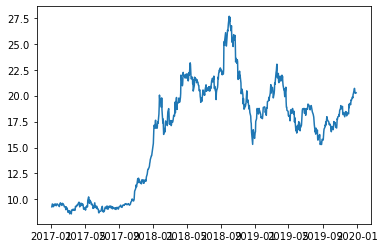

In [ ]:
plt.plot(df['Close'])

In [ ]:
sample = df['Close'][:800]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [ ]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -1.3791265408983748
p-value: 0.5922412052320963,
N: 749, 
critical values: {'1%': -3.439110818166223, '5%': -2.8654065210185795, '10%': -2.568828945705979}


In [ ]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [ ]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [ ]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 1


In [ ]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

In [ ]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

In [ ]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [ ]:
n_steps_ahead

4

In [ ]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [ ]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(598, 1, 1), (598, 1), (147, 1, 1), (147, 1)]


In [ ]:
def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
max_epochs = 20 #Dejar mil
batch_size = 1000

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [ ]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [ ]:
params

{'rnn': {'model': None,
  'function': <function __main__.SimpleRNN_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 20,
  'color': 'blue',
  'label': 'RNN'},
 'gru': {'model': None,
  'function': <function __main__.GRU_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'orange',
  'label': 'GRU'},
 'lstm': {'model': None,
  'function': <function __main__.LSTM_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'red',
  'label': 'LSTM'}}

In [ ]:
do_training = True

In [ ]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/20


C:\Users\svill\AppData\Local\Temp/ipykernel_7464/719261985.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


1/1 - 0s - loss: 0.5392 - 330ms/epoch - 330ms/step
Epoch 2/20
1/1 - 0s - loss: 0.5299 - 10ms/epoch - 10ms/step
Epoch 3/20
1/1 - 0s - loss: 0.5207 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 0.5116 - 10ms/epoch - 10ms/step
Epoch 5/20
1/1 - 0s - loss: 0.5026 - 6ms/epoch - 6ms/step
Epoch 6/20
1/1 - 0s - loss: 0.4937 - 8ms/epoch - 8ms/step
Epoch 7/20
1/1 - 0s - loss: 0.4848 - 5ms/epoch - 5ms/step
Epoch 8/20
1/1 - 0s - loss: 0.4761 - 4ms/epoch - 4ms/step
Epoch 9/20
1/1 - 0s - loss: 0.4675 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 0.4589 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 0.4505 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 0.4421 - 6ms/epoch - 6ms/step
Epoch 13/20
1/1 - 0s - loss: 0.4338 - 6ms/epoch - 6ms/step
Epoch 14/20
1/1 - 0s - loss: 0.4257 - 8ms/epoch - 8ms/step
Epoch 15/20
1/1 - 0s - loss: 0.4176 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 0.4097 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 0.4018 - 10ms/epoch - 10ms/step
Epoch 18/20

Epoch 8/20
1/1 - 0s - loss: 1.0956 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 1.0695 - 0s/epoch - 0s/step
Epoch 10/20
1/1 - 0s - loss: 1.0438 - 10ms/epoch - 10ms/step
Epoch 11/20
1/1 - 0s - loss: 1.0185 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 0.9935 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 0.9690 - 8ms/epoch - 8ms/step
Epoch 14/20
1/1 - 0s - loss: 0.9449 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 0.9212 - 13ms/epoch - 13ms/step
Epoch 16/20
1/1 - 0s - loss: 0.8980 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 0.8751 - 0s/epoch - 0s/step
Epoch 18/20
1/1 - 0s - loss: 0.8526 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 0.8306 - 3ms/epoch - 3ms/step
Epoch 20/20
1/1 - 0s - loss: 0.8089 - 6ms/epoch - 6ms/step
1/1 - 0s - loss: 0.6948 - 86ms/epoch - 86ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.5s
Epoch 1/20
1/1 - 0s - loss: 0.6425 - 313ms/epoch - 313ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6330 - 0s/epoch -

1/1 - 0s - loss: 0.4458 - 8ms/epoch - 8ms/step
Epoch 16/20
1/1 - 0s - loss: 0.4387 - 6ms/epoch - 6ms/step
Epoch 17/20
1/1 - 0s - loss: 0.4318 - 4ms/epoch - 4ms/step
Epoch 18/20
1/1 - 0s - loss: 0.4249 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 0.4181 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 0.4113 - 0s/epoch - 0s/step
1/1 - 0s - loss: 3.9160 - 111ms/epoch - 111ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.5s
Epoch 1/20
1/1 - 0s - loss: 4.5103 - 285ms/epoch - 285ms/step
Epoch 2/20
1/1 - 0s - loss: 4.4613 - 7ms/epoch - 7ms/step
Epoch 3/20
1/1 - 0s - loss: 4.4127 - 4ms/epoch - 4ms/step
Epoch 4/20
1/1 - 0s - loss: 4.3644 - 6ms/epoch - 6ms/step
Epoch 5/20
1/1 - 0s - loss: 4.3165 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 4.2690 - 0s/epoch - 0s/step
Epoch 7/20
1/1 - 0s - loss: 4.2218 - 10ms/epoch - 10ms/step
Epoch 8/20
1/1 - 0s - loss: 4.1750 - 10ms/epoch - 10ms/step
Epoch 9/20
1/1 - 0s - loss: 4.1286 - 0s/epoch - 0s/step
Epoc

[CV] END ............................l1_reg=0.001, n_units=5; total time=   0.5s
Epoch 1/20
1/1 - 0s - loss: 1.3037 - 340ms/epoch - 340ms/step
Epoch 2/20
1/1 - 0s - loss: 1.2942 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 1.2847 - 3ms/epoch - 3ms/step
Epoch 4/20
1/1 - 0s - loss: 1.2753 - 6ms/epoch - 6ms/step
Epoch 5/20
1/1 - 0s - loss: 1.2659 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 1.2565 - 0s/epoch - 0s/step
Epoch 7/20
1/1 - 0s - loss: 1.2472 - 9ms/epoch - 9ms/step
Epoch 8/20
1/1 - 0s - loss: 1.2379 - 6ms/epoch - 6ms/step
Epoch 9/20
1/1 - 0s - loss: 1.2286 - 7ms/epoch - 7ms/step
Epoch 10/20
1/1 - 0s - loss: 1.2194 - 6ms/epoch - 6ms/step
Epoch 11/20
1/1 - 0s - loss: 1.2103 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 1.2011 - 8ms/epoch - 8ms/step
Epoch 13/20
1/1 - 0s - loss: 1.1921 - 5ms/epoch - 5ms/step
Epoch 14/20
1/1 - 0s - loss: 1.1830 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 1.1740 - 9ms/epoch - 9ms/step
Epoch 16/20
1/1 - 0s - loss: 1.1651 - 11ms/epoch 

Epoch 7/20
1/1 - 0s - loss: 3.9092 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 3.8373 - 10ms/epoch - 10ms/step
Epoch 9/20
1/1 - 0s - loss: 3.7661 - 0s/epoch - 0s/step
Epoch 10/20
1/1 - 0s - loss: 3.6955 - 10ms/epoch - 10ms/step
Epoch 11/20
1/1 - 0s - loss: 3.6257 - 3ms/epoch - 3ms/step
Epoch 12/20
1/1 - 0s - loss: 3.5565 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 3.4881 - 9ms/epoch - 9ms/step
Epoch 14/20
1/1 - 0s - loss: 3.4204 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 3.3535 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 3.2873 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 3.2218 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 3.1571 - 7ms/epoch - 7ms/step
Epoch 19/20
1/1 - 0s - loss: 3.0932 - 7ms/epoch - 7ms/step
Epoch 20/20
1/1 - 0s - loss: 3.0300 - 973us/epoch - 973us/step
1/1 - 0s - loss: 2.9608 - 80ms/epoch - 80ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=   0.5s
Epoch 1/20
1/1 - 0s - loss: 0.5074 - 327ms/epoch 

1/1 - 0s - loss: 3.3281 - 4ms/epoch - 4ms/step
Epoch 15/20
1/1 - 0s - loss: 3.3071 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 3.2862 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 3.2653 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 3.2444 - 11ms/epoch - 11ms/step
Epoch 19/20
1/1 - 0s - loss: 3.2237 - 6ms/epoch - 6ms/step
Epoch 20/20
1/1 - 0s - loss: 3.2030 - 9ms/epoch - 9ms/step
1/1 - 0s - loss: 0.8460 - 100ms/epoch - 100ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=   0.6s
Epoch 1/20
1/1 - 0s - loss: 0.6830 - 330ms/epoch - 330ms/step
Epoch 2/20
1/1 - 0s - loss: 0.6790 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 0.6751 - 11ms/epoch - 11ms/step
Epoch 4/20
1/1 - 0s - loss: 0.6711 - 9ms/epoch - 9ms/step
Epoch 5/20
1/1 - 0s - loss: 0.6672 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 0.6633 - 9ms/epoch - 9ms/step
Epoch 7/20
1/1 - 0s - loss: 0.6595 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 0.6556 - 0s/epoch - 0s/step
Epoch 9

[CV] END ............................l1_reg=0.01, n_units=10; total time=   0.6s
Epoch 1/20
1/1 - 0s - loss: 3.7788 - 307ms/epoch - 307ms/step
Epoch 2/20
1/1 - 0s - loss: 3.7443 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 3.7099 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 3.6757 - 0s/epoch - 0s/step
Epoch 5/20
1/1 - 0s - loss: 3.6417 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 3.6078 - 5ms/epoch - 5ms/step
Epoch 7/20
1/1 - 0s - loss: 3.5741 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 3.5406 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 3.5073 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 3.4742 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 3.4412 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 3.4084 - 14ms/epoch - 14ms/step
Epoch 13/20
1/1 - 0s - loss: 3.3758 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 3.3434 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 3.3112 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 3.2792 - 10ms/epoch 

Epoch 7/20
1/1 - 0s - loss: 3.2967 - 10ms/epoch - 10ms/step
Epoch 8/20
1/1 - 0s - loss: 3.2618 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 3.2271 - 908us/epoch - 908us/step
Epoch 10/20
1/1 - 0s - loss: 3.1926 - 9ms/epoch - 9ms/step
Epoch 11/20
1/1 - 0s - loss: 3.1583 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 3.1243 - 4ms/epoch - 4ms/step
Epoch 13/20
1/1 - 0s - loss: 3.0905 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 3.0570 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 3.0237 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 2.9907 - 4ms/epoch - 4ms/step
Epoch 17/20
1/1 - 0s - loss: 2.9579 - 7ms/epoch - 7ms/step
Epoch 18/20
1/1 - 0s - loss: 2.9254 - 6ms/epoch - 6ms/step
Epoch 19/20
1/1 - 0s - loss: 2.8931 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 2.8610 - 10ms/epoch - 10ms/step
1/1 - 0s - loss: 2.0714 - 130ms/epoch - 130ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=   0.7s
Epoch 1/20
1/1 - 0s - loss: 4.0379 - 313m

1/1 - 0s - loss: 2.4439 - 11ms/epoch - 11ms/step
Epoch 15/20
1/1 - 0s - loss: 2.4180 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 2.3923 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 2.3669 - 11ms/epoch - 11ms/step
Epoch 18/20
1/1 - 0s - loss: 2.3417 - 0s/epoch - 0s/step
Epoch 19/20
1/1 - 0s - loss: 2.3167 - 13ms/epoch - 13ms/step
Epoch 20/20
1/1 - 0s - loss: 2.2919 - 0s/epoch - 0s/step
1/1 - 0s - loss: 2.2875 - 85ms/epoch - 85ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=   0.5s
Epoch 1/20
1/1 - 0s - loss: 1.2274 - 312ms/epoch - 312ms/step
Epoch 2/20
1/1 - 0s - loss: 1.2110 - 1ms/epoch - 1ms/step
Epoch 3/20
1/1 - 0s - loss: 1.1950 - 9ms/epoch - 9ms/step
Epoch 4/20
1/1 - 0s - loss: 1.1792 - 5ms/epoch - 5ms/step
Epoch 5/20
1/1 - 0s - loss: 1.1637 - 6ms/epoch - 6ms/step
Epoch 6/20
1/1 - 0s - loss: 1.1486 - 0s/epoch - 0s/step
Epoch 7/20
1/1 - 0s - loss: 1.1337 - 7ms/epoch - 7ms/step
Epoch 8/20
1/1 - 0s - loss: 1.1191 - 0s/epoch - 0s/step
Epoch 9

1/1 - 0s - loss: 2.2008 - 90ms/epoch - 90ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=   0.5s
Epoch 1/20
1/1 - 0s - loss: 1.9423 - 320ms/epoch - 320ms/step
Epoch 2/20
1/1 - 0s - loss: 1.9191 - 11ms/epoch - 11ms/step
Epoch 3/20
1/1 - 0s - loss: 1.8965 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 1.8746 - 11ms/epoch - 11ms/step
Epoch 5/20
1/1 - 0s - loss: 1.8532 - 8ms/epoch - 8ms/step
Epoch 6/20
1/1 - 0s - loss: 1.8323 - 5ms/epoch - 5ms/step
Epoch 7/20
1/1 - 0s - loss: 1.8120 - 2ms/epoch - 2ms/step
Epoch 8/20
1/1 - 0s - loss: 1.7922 - 7ms/epoch - 7ms/step
Epoch 9/20
1/1 - 0s - loss: 1.7729 - 5ms/epoch - 5ms/step
Epoch 10/20
1/1 - 0s - loss: 1.7544 - 7ms/epoch - 7ms/step
Epoch 11/20
1/1 - 0s - loss: 1.7364 - 8ms/epoch - 8ms/step
Epoch 12/20
1/1 - 0s - loss: 1.7189 - 8ms/epoch - 8ms/step
Epoch 13/20
1/1 - 0s - loss: 1.7020 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 1.6856 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 1.6697 - 8ms/epoch - 8

C:\Users\svill\AppData\Local\Temp/ipykernel_7464/719261985.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


1/1 - 0s - loss: 1.6216 - 396ms/epoch - 396ms/step
Epoch 2/20
1/1 - 0s - loss: 1.6022 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 1.5829 - 4ms/epoch - 4ms/step
Epoch 4/20
1/1 - 0s - loss: 1.5637 - 6ms/epoch - 6ms/step
Epoch 5/20
1/1 - 0s - loss: 1.5447 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 1.5259 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.5072 - 9ms/epoch - 9ms/step
Epoch 8/20
1/1 - 0s - loss: 1.4886 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 1.4702 - 11ms/epoch - 11ms/step
Epoch 10/20
1/1 - 0s - loss: 1.4520 - 5ms/epoch - 5ms/step
Epoch 11/20
1/1 - 0s - loss: 1.4340 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 1.4161 - 11ms/epoch - 11ms/step
Epoch 13/20
1/1 - 0s - loss: 1.3984 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 1.3808 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 1.3634 - 9ms/epoch - 9ms/step
Epoch 16/20
1/1 - 0s - loss: 1.3461 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 1.3291 - 5ms/epoch - 5ms/step
Epoch 18/20
1/1 - 0

Epoch 8/20
1/1 - 0s - loss: 3.0915 - 605us/epoch - 605us/step
Epoch 9/20
1/1 - 0s - loss: 3.0680 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 3.0446 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 3.0213 - 8ms/epoch - 8ms/step
Epoch 12/20
1/1 - 0s - loss: 2.9982 - 5ms/epoch - 5ms/step
Epoch 13/20
1/1 - 0s - loss: 2.9751 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 2.9522 - 8ms/epoch - 8ms/step
Epoch 15/20
1/1 - 0s - loss: 2.9295 - 8ms/epoch - 8ms/step
Epoch 16/20
1/1 - 0s - loss: 2.9068 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 2.8843 - 4ms/epoch - 4ms/step
Epoch 18/20
1/1 - 0s - loss: 2.8618 - 4ms/epoch - 4ms/step
Epoch 19/20
1/1 - 0s - loss: 2.8396 - 4ms/epoch - 4ms/step
Epoch 20/20
1/1 - 0s - loss: 2.8174 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.6717 - 127ms/epoch - 127ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.7s
Epoch 1/20
1/1 - 1s - loss: 0.3350 - 503ms/epoch - 503ms/step
Epoch 2/20
1/1 - 0s - loss: 0.3331 - 8m

Epoch 15/20
1/1 - 0s - loss: 1.1607 - 8ms/epoch - 8ms/step
Epoch 16/20
1/1 - 0s - loss: 1.1450 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 1.1294 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 1.1139 - 5ms/epoch - 5ms/step
Epoch 19/20
1/1 - 0s - loss: 1.0985 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 1.0832 - 10ms/epoch - 10ms/step
1/1 - 0s - loss: 0.8684 - 89ms/epoch - 89ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   1.0s
Epoch 1/20
1/1 - 0s - loss: 1.1034 - 384ms/epoch - 384ms/step
Epoch 2/20
1/1 - 0s - loss: 1.0880 - 7ms/epoch - 7ms/step
Epoch 3/20
1/1 - 0s - loss: 1.0727 - 8ms/epoch - 8ms/step
Epoch 4/20
1/1 - 0s - loss: 1.0575 - 4ms/epoch - 4ms/step
Epoch 5/20
1/1 - 0s - loss: 1.0425 - 5ms/epoch - 5ms/step
Epoch 6/20
1/1 - 0s - loss: 1.0277 - 3ms/epoch - 3ms/step
Epoch 7/20
1/1 - 0s - loss: 1.0129 - 7ms/epoch - 7ms/step
Epoch 8/20
1/1 - 0s - loss: 0.9984 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 0.9839 - 0s/epoch - 0s

Epoch 1/20
1/1 - 0s - loss: 2.2144 - 373ms/epoch - 373ms/step
Epoch 2/20
1/1 - 0s - loss: 2.2017 - 8ms/epoch - 8ms/step
Epoch 3/20
1/1 - 0s - loss: 2.1890 - 8ms/epoch - 8ms/step
Epoch 4/20
1/1 - 0s - loss: 2.1763 - 5ms/epoch - 5ms/step
Epoch 5/20
1/1 - 0s - loss: 2.1637 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 2.1512 - 9ms/epoch - 9ms/step
Epoch 7/20
1/1 - 0s - loss: 2.1387 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 2.1263 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 2.1139 - 12ms/epoch - 12ms/step
Epoch 10/20
1/1 - 0s - loss: 2.1016 - 4ms/epoch - 4ms/step
Epoch 11/20
1/1 - 0s - loss: 2.0893 - 7ms/epoch - 7ms/step
Epoch 12/20
1/1 - 0s - loss: 2.0771 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 2.0650 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 2.0529 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 2.0409 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 2.0290 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 2.0171 - 11ms/epoch - 11ms/step
Epoc

Epoch 8/20
1/1 - 0s - loss: 3.4643 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 3.4277 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 3.3913 - 0s/epoch - 0s/step
Epoch 11/20
1/1 - 0s - loss: 3.3551 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 3.3190 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 3.2830 - 8ms/epoch - 8ms/step
Epoch 14/20
1/1 - 0s - loss: 3.2473 - 2ms/epoch - 2ms/step
Epoch 15/20
1/1 - 0s - loss: 3.2117 - 9ms/epoch - 9ms/step
Epoch 16/20
1/1 - 0s - loss: 3.1762 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 3.1410 - 3ms/epoch - 3ms/step
Epoch 18/20
1/1 - 0s - loss: 3.1058 - 8ms/epoch - 8ms/step
Epoch 19/20
1/1 - 0s - loss: 3.0709 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 3.0361 - 0s/epoch - 0s/step
1/1 - 0s - loss: 3.0205 - 100ms/epoch - 100ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=   0.6s
Epoch 1/20
1/1 - 1s - loss: 6.7491 - 711ms/epoch - 711ms/step
Epoch 2/20
1/1 - 0s - loss: 6.6931 - 4ms/epoch 

Epoch 15/20
1/1 - 0s - loss: 9.4129 - 11ms/epoch - 11ms/step
Epoch 16/20
1/1 - 0s - loss: 9.3818 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 9.3509 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 9.3201 - 11ms/epoch - 11ms/step
Epoch 19/20
1/1 - 0s - loss: 9.2895 - 6ms/epoch - 6ms/step
Epoch 20/20
1/1 - 0s - loss: 9.2591 - 0s/epoch - 0s/step
1/1 - 0s - loss: 3.5829 - 100ms/epoch - 100ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=   0.6s
Epoch 1/20
1/1 - 0s - loss: 0.8783 - 385ms/epoch - 385ms/step
Epoch 2/20
1/1 - 0s - loss: 0.8726 - 8ms/epoch - 8ms/step
Epoch 3/20
1/1 - 0s - loss: 0.8669 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 0.8613 - 0s/epoch - 0s/step
Epoch 5/20
1/1 - 0s - loss: 0.8557 - 10ms/epoch - 10ms/step
Epoch 6/20
1/1 - 0s - loss: 0.8502 - 0s/epoch - 0s/step
Epoch 7/20
1/1 - 0s - loss: 0.8447 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 0.8392 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 0.8339 - 0s/epoch - 0s/ste

Epoch 1/20
1/1 - 0s - loss: 2.8442 - 374ms/epoch - 374ms/step
Epoch 2/20
1/1 - 0s - loss: 2.8298 - 2ms/epoch - 2ms/step
Epoch 3/20
1/1 - 0s - loss: 2.8154 - 8ms/epoch - 8ms/step
Epoch 4/20
1/1 - 0s - loss: 2.8011 - 10ms/epoch - 10ms/step
Epoch 5/20
1/1 - 0s - loss: 2.7868 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 2.7725 - 0s/epoch - 0s/step
Epoch 7/20
1/1 - 0s - loss: 2.7583 - 9ms/epoch - 9ms/step
Epoch 8/20
1/1 - 0s - loss: 2.7441 - 8ms/epoch - 8ms/step
Epoch 9/20
1/1 - 0s - loss: 2.7299 - 0s/epoch - 0s/step
Epoch 10/20
1/1 - 0s - loss: 2.7157 - 10ms/epoch - 10ms/step
Epoch 11/20
1/1 - 0s - loss: 2.7016 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 2.6875 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 2.6735 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 2.6594 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 2.6454 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 2.6314 - 17ms/epoch - 17ms/step
Epoch 17/20
1/1 - 0s - loss: 2.6175 - 3ms/epoch - 3ms/step
Epoch 18

Epoch 8/20
1/1 - 0s - loss: 1.3480 - 9ms/epoch - 9ms/step
Epoch 9/20
1/1 - 0s - loss: 1.3332 - 6ms/epoch - 6ms/step
Epoch 10/20
1/1 - 0s - loss: 1.3185 - 4ms/epoch - 4ms/step
Epoch 11/20
1/1 - 0s - loss: 1.3039 - 7ms/epoch - 7ms/step
Epoch 12/20
1/1 - 0s - loss: 1.2894 - 8ms/epoch - 8ms/step
Epoch 13/20
1/1 - 0s - loss: 1.2750 - 11ms/epoch - 11ms/step
Epoch 14/20
1/1 - 0s - loss: 1.2608 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 1.2466 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.2325 - 9ms/epoch - 9ms/step
Epoch 17/20
1/1 - 0s - loss: 1.2186 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 1.2047 - 0s/epoch - 0s/step
Epoch 19/20
1/1 - 0s - loss: 1.1910 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 1.1773 - 10ms/epoch - 10ms/step
1/1 - 0s - loss: 1.4734 - 114ms/epoch - 114ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=   0.8s
Epoch 1/20
1/1 - 0s - loss: 8.5954 - 431ms/epoch - 431ms/step
Epoch 2/20
1/1 - 0s - loss: 8.5712 - 5ms/

Epoch 15/20
1/1 - 0s - loss: 4.1439 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 4.1169 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 4.0900 - 10ms/epoch - 10ms/step
Epoch 18/20
1/1 - 0s - loss: 4.0633 - 5ms/epoch - 5ms/step
Epoch 19/20
1/1 - 0s - loss: 4.0368 - 6ms/epoch - 6ms/step
Epoch 20/20
1/1 - 0s - loss: 4.0104 - 0s/epoch - 0s/step
1/1 - 0s - loss: 4.0058 - 90ms/epoch - 90ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=   0.7s
Epoch 1/20
1/1 - 0s - loss: 1.1463 - 457ms/epoch - 457ms/step
Epoch 2/20
1/1 - 0s - loss: 1.1400 - 6ms/epoch - 6ms/step
Epoch 3/20
1/1 - 0s - loss: 1.1339 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 1.1278 - 8ms/epoch - 8ms/step
Epoch 5/20
1/1 - 0s - loss: 1.1219 - 7ms/epoch - 7ms/step
Epoch 6/20
1/1 - 0s - loss: 1.1161 - 5ms/epoch - 5ms/step
Epoch 7/20
1/1 - 0s - loss: 1.1104 - 6ms/epoch - 6ms/step
Epoch 8/20
1/1 - 0s - loss: 1.1047 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 1.0992 - 3ms/epoch - 3ms/ste

[CV] END .............................l1_reg=0.1, n_units=20; total time=   0.9s
Epoch 1/20
1/1 - 0s - loss: 2.1323 - 413ms/epoch - 413ms/step
Epoch 2/20
1/1 - 0s - loss: 2.1201 - 4ms/epoch - 4ms/step
Epoch 3/20
1/1 - 0s - loss: 2.1080 - 7ms/epoch - 7ms/step
Epoch 4/20
1/1 - 0s - loss: 2.0962 - 0s/epoch - 0s/step
Epoch 5/20
1/1 - 0s - loss: 2.0845 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 2.0731 - 4ms/epoch - 4ms/step
Epoch 7/20
1/1 - 0s - loss: 2.0619 - 6ms/epoch - 6ms/step
Epoch 8/20
1/1 - 0s - loss: 2.0509 - 4ms/epoch - 4ms/step
Epoch 9/20
1/1 - 0s - loss: 2.0400 - 0s/epoch - 0s/step
Epoch 10/20
1/1 - 0s - loss: 2.0293 - 0s/epoch - 0s/step
Epoch 11/20
1/1 - 0s - loss: 2.0187 - 8ms/epoch - 8ms/step
Epoch 12/20
1/1 - 0s - loss: 2.0084 - 8ms/epoch - 8ms/step
Epoch 13/20
1/1 - 0s - loss: 1.9983 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 1.9884 - 12ms/epoch - 12ms/step
Epoch 15/20
1/1 - 0s - loss: 1.9786 - 3ms/epoch - 3ms/step
Epoch 16/20
1/1 - 0s - loss: 1.9689 - 0s/epoch 

C:\Users\svill\AppData\Local\Temp/ipykernel_7464/719261985.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


1/1 - 0s - loss: 0.0953 - 438ms/epoch - 438ms/step
Epoch 2/20
1/1 - 0s - loss: 0.0936 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 0.0920 - 4ms/epoch - 4ms/step
Epoch 4/20
1/1 - 0s - loss: 0.0904 - 6ms/epoch - 6ms/step
Epoch 5/20
1/1 - 0s - loss: 0.0888 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 0.0872 - 657us/epoch - 657us/step
Epoch 7/20
1/1 - 0s - loss: 0.0857 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 0.0841 - 14ms/epoch - 14ms/step
Epoch 9/20
1/1 - 0s - loss: 0.0826 - 4ms/epoch - 4ms/step
Epoch 10/20
1/1 - 0s - loss: 0.0811 - 0s/epoch - 0s/step
Epoch 11/20
1/1 - 0s - loss: 0.0796 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 0.0781 - 3ms/epoch - 3ms/step
Epoch 13/20
1/1 - 0s - loss: 0.0766 - 9ms/epoch - 9ms/step
Epoch 14/20
1/1 - 0s - loss: 0.0752 - 5ms/epoch - 5ms/step
Epoch 15/20
1/1 - 0s - loss: 0.0737 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 0.0723 - 5ms/epoch - 5ms/step
Epoch 17/20
1/1 - 0s - loss: 0.0709 - 4ms/epoch - 4ms/step
Epoch 18/20
1/1 - 0

Epoch 8/20
1/1 - 0s - loss: 3.3349 - 2ms/epoch - 2ms/step
Epoch 9/20
1/1 - 0s - loss: 3.3200 - 4ms/epoch - 4ms/step
Epoch 10/20
1/1 - 0s - loss: 3.3051 - 6ms/epoch - 6ms/step
Epoch 11/20
1/1 - 0s - loss: 3.2902 - 5ms/epoch - 5ms/step
Epoch 12/20
1/1 - 0s - loss: 3.2753 - 4ms/epoch - 4ms/step
Epoch 13/20
1/1 - 0s - loss: 3.2605 - 4ms/epoch - 4ms/step
Epoch 14/20
1/1 - 0s - loss: 3.2457 - 8ms/epoch - 8ms/step
Epoch 15/20
1/1 - 0s - loss: 3.2309 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 3.2162 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 3.2015 - 6ms/epoch - 6ms/step
Epoch 18/20
1/1 - 0s - loss: 3.1869 - 6ms/epoch - 6ms/step
Epoch 19/20
1/1 - 0s - loss: 3.1723 - 8ms/epoch - 8ms/step
Epoch 20/20
1/1 - 0s - loss: 3.1577 - 0s/epoch - 0s/step
1/1 - 0s - loss: 0.7980 - 127ms/epoch - 127ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.7s
Epoch 1/20
1/1 - 0s - loss: 1.1574 - 448ms/epoch - 448ms/step
Epoch 2/20
1/1 - 0s - loss: 1.1502 - 0s/epo

Epoch 15/20
1/1 - 0s - loss: 0.9676 - 9ms/epoch - 9ms/step
Epoch 16/20
1/1 - 0s - loss: 0.9600 - 7ms/epoch - 7ms/step
Epoch 17/20
1/1 - 0s - loss: 0.9526 - 3ms/epoch - 3ms/step
Epoch 18/20
1/1 - 0s - loss: 0.9451 - 7ms/epoch - 7ms/step
Epoch 19/20
1/1 - 0s - loss: 0.9377 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 0.9303 - 0s/epoch - 0s/step
1/1 - 0s - loss: 0.6690 - 100ms/epoch - 100ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/20
1/1 - 1s - loss: 3.7679 - 550ms/epoch - 550ms/step
Epoch 2/20
1/1 - 0s - loss: 3.7518 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 3.7357 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 3.7196 - 10ms/epoch - 10ms/step
Epoch 5/20
1/1 - 0s - loss: 3.7036 - 9ms/epoch - 9ms/step
Epoch 6/20
1/1 - 0s - loss: 3.6876 - 12ms/epoch - 12ms/step
Epoch 7/20
1/1 - 0s - loss: 3.6717 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 3.6558 - 8ms/epoch - 8ms/step
Epoch 9/20
1/1 - 0s - loss: 3.6399 - 8ms/epoch

[CV] END ............................l1_reg=0.001, n_units=5; total time=   0.6s
Epoch 1/20
1/1 - 0s - loss: 1.2442 - 355ms/epoch - 355ms/step
Epoch 2/20
1/1 - 0s - loss: 1.2397 - 8ms/epoch - 8ms/step
Epoch 3/20
1/1 - 0s - loss: 1.2351 - 4ms/epoch - 4ms/step
Epoch 4/20
1/1 - 0s - loss: 1.2306 - 8ms/epoch - 8ms/step
Epoch 5/20
1/1 - 0s - loss: 1.2260 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 1.2214 - 11ms/epoch - 11ms/step
Epoch 7/20
1/1 - 0s - loss: 1.2169 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 1.2124 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 1.2078 - 10ms/epoch - 10ms/step
Epoch 10/20
1/1 - 0s - loss: 1.2033 - 0s/epoch - 0s/step
Epoch 11/20
1/1 - 0s - loss: 1.1987 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.1942 - 6ms/epoch - 6ms/step
Epoch 13/20
1/1 - 0s - loss: 1.1897 - 4ms/epoch - 4ms/step
Epoch 14/20
1/1 - 0s - loss: 1.1851 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 1.1806 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 1.1761 - 12m

Epoch 7/20
1/1 - 0s - loss: 8.2046 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 8.1710 - 3ms/epoch - 3ms/step
Epoch 9/20
1/1 - 0s - loss: 8.1376 - 7ms/epoch - 7ms/step
Epoch 10/20
1/1 - 0s - loss: 8.1042 - 5ms/epoch - 5ms/step
Epoch 11/20
1/1 - 0s - loss: 8.0708 - 4ms/epoch - 4ms/step
Epoch 12/20
1/1 - 0s - loss: 8.0375 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 8.0043 - 4ms/epoch - 4ms/step
Epoch 14/20
1/1 - 0s - loss: 7.9711 - 6ms/epoch - 6ms/step
Epoch 15/20
1/1 - 0s - loss: 7.9379 - 4ms/epoch - 4ms/step
Epoch 16/20
1/1 - 0s - loss: 7.9049 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 7.8718 - 9ms/epoch - 9ms/step
Epoch 18/20
1/1 - 0s - loss: 7.8388 - 0s/epoch - 0s/step
Epoch 19/20
1/1 - 0s - loss: 7.8058 - 10ms/epoch - 10ms/step
Epoch 20/20
1/1 - 0s - loss: 7.7729 - 548us/epoch - 548us/step
1/1 - 0s - loss: 7.7853 - 128ms/epoch - 128ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=   0.6s
Epoch 1/20
1/1 - 0s - loss: 0.8863 - 362ms/

Epoch 14/20
1/1 - 0s - loss: 5.3187 - 6ms/epoch - 6ms/step
Epoch 15/20
1/1 - 0s - loss: 5.3048 - 6ms/epoch - 6ms/step
Epoch 16/20
1/1 - 0s - loss: 5.2910 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 5.2772 - 4ms/epoch - 4ms/step
Epoch 18/20
1/1 - 0s - loss: 5.2635 - 0s/epoch - 0s/step
Epoch 19/20
1/1 - 0s - loss: 5.2497 - 10ms/epoch - 10ms/step
Epoch 20/20
1/1 - 0s - loss: 5.2359 - 0s/epoch - 0s/step
1/1 - 0s - loss: 2.1376 - 160ms/epoch - 160ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=   1.6s
Epoch 1/20
1/1 - 1s - loss: 3.3341 - 552ms/epoch - 552ms/step
Epoch 2/20
1/1 - 0s - loss: 3.3226 - 4ms/epoch - 4ms/step
Epoch 3/20
1/1 - 0s - loss: 3.3110 - 6ms/epoch - 6ms/step
Epoch 4/20
1/1 - 0s - loss: 3.2995 - 4ms/epoch - 4ms/step
Epoch 5/20
1/1 - 0s - loss: 3.2880 - 4ms/epoch - 4ms/step
Epoch 6/20
1/1 - 0s - loss: 3.2766 - 9ms/epoch - 9ms/step
Epoch 7/20
1/1 - 0s - loss: 3.2652 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 3.2538 - 5ms/epoch - 

1/1 - 0s - loss: 6.4637 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.7676 - 147ms/epoch - 147ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=   0.7s
Epoch 1/20
1/1 - 1s - loss: 2.0074 - 640ms/epoch - 640ms/step
Epoch 2/20
1/1 - 0s - loss: 1.9987 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 1.9900 - 12ms/epoch - 12ms/step
Epoch 4/20
1/1 - 0s - loss: 1.9814 - 6ms/epoch - 6ms/step
Epoch 5/20
1/1 - 0s - loss: 1.9728 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 1.9642 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.9556 - 0s/epoch - 0s/step
Epoch 8/20
1/1 - 0s - loss: 1.9471 - 10ms/epoch - 10ms/step
Epoch 9/20
1/1 - 0s - loss: 1.9385 - 10ms/epoch - 10ms/step
Epoch 10/20
1/1 - 0s - loss: 1.9300 - 10ms/epoch - 10ms/step
Epoch 11/20
1/1 - 0s - loss: 1.9215 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 1.9131 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 1.9046 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 1.8962 - 4ms/epoch - 4ms/step
Ep

Epoch 5/20
1/1 - 0s - loss: 4.1263 - 3ms/epoch - 3ms/step
Epoch 6/20
1/1 - 0s - loss: 4.1114 - 3ms/epoch - 3ms/step
Epoch 7/20
1/1 - 0s - loss: 4.0965 - 2ms/epoch - 2ms/step
Epoch 8/20
1/1 - 0s - loss: 4.0816 - 8ms/epoch - 8ms/step
Epoch 9/20
1/1 - 0s - loss: 4.0667 - 9ms/epoch - 9ms/step
Epoch 10/20
1/1 - 0s - loss: 4.0518 - 7ms/epoch - 7ms/step
Epoch 11/20
1/1 - 0s - loss: 4.0370 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 4.0222 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 4.0074 - 8ms/epoch - 8ms/step
Epoch 14/20
1/1 - 0s - loss: 3.9926 - 8ms/epoch - 8ms/step
Epoch 15/20
1/1 - 0s - loss: 3.9778 - 12ms/epoch - 12ms/step
Epoch 16/20
1/1 - 0s - loss: 3.9631 - 2ms/epoch - 2ms/step
Epoch 17/20
1/1 - 0s - loss: 3.9484 - 9ms/epoch - 9ms/step
Epoch 18/20
1/1 - 0s - loss: 3.9336 - 5ms/epoch - 5ms/step
Epoch 19/20
1/1 - 0s - loss: 3.9189 - 3ms/epoch - 3ms/step
Epoch 20/20
1/1 - 0s - loss: 3.9042 - 9ms/epoch - 9ms/step
1/1 - 0s - loss: 1.1331 - 152ms/epoch - 152ms/step
[CV] END ...

Epoch 12/20
1/1 - 0s - loss: 3.2927 - 7ms/epoch - 7ms/step
Epoch 13/20
1/1 - 0s - loss: 3.2790 - 3ms/epoch - 3ms/step
Epoch 14/20
1/1 - 0s - loss: 3.2653 - 7ms/epoch - 7ms/step
Epoch 15/20
1/1 - 0s - loss: 3.2517 - 0s/epoch - 0s/step
Epoch 16/20
1/1 - 0s - loss: 3.2381 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 3.2245 - 0s/epoch - 0s/step
Epoch 18/20
1/1 - 0s - loss: 3.2110 - 0s/epoch - 0s/step
Epoch 19/20
1/1 - 0s - loss: 3.1974 - 1ms/epoch - 1ms/step
Epoch 20/20
1/1 - 0s - loss: 3.1839 - 10ms/epoch - 10ms/step
1/1 - 0s - loss: 3.1883 - 131ms/epoch - 131ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=   0.6s
Epoch 1/20
1/1 - 0s - loss: 1.9178 - 430ms/epoch - 430ms/step
Epoch 2/20
1/1 - 0s - loss: 1.9083 - 1ms/epoch - 1ms/step
Epoch 3/20
1/1 - 0s - loss: 1.8990 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 1.8896 - 4ms/epoch - 4ms/step
Epoch 5/20
1/1 - 0s - loss: 1.8803 - 7ms/epoch - 7ms/step
Epoch 6/20
1/1 - 0s - loss: 1.8711 - 0s/epoch -

Epoch 19/20
1/1 - 0s - loss: 3.0395 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 3.0217 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 1.8134 - 155ms/epoch - 155ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=   0.8s
Epoch 1/20
1/1 - 1s - loss: 3.7395 - 848ms/epoch - 848ms/step
Epoch 2/20
1/1 - 0s - loss: 3.7207 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 3.7020 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 3.6835 - 2ms/epoch - 2ms/step
Epoch 5/20
1/1 - 0s - loss: 3.6650 - 10ms/epoch - 10ms/step
Epoch 6/20
1/1 - 0s - loss: 3.6465 - 11ms/epoch - 11ms/step
Epoch 7/20
1/1 - 0s - loss: 3.6282 - 9ms/epoch - 9ms/step
Epoch 8/20
1/1 - 0s - loss: 3.6101 - 10ms/epoch - 10ms/step
Epoch 9/20
1/1 - 0s - loss: 3.5922 - 7ms/epoch - 7ms/step
Epoch 10/20
1/1 - 0s - loss: 3.5741 - 3ms/epoch - 3ms/step
Epoch 11/20
1/1 - 0s - loss: 3.5562 - 7ms/epoch - 7ms/step
Epoch 12/20
1/1 - 0s - loss: 3.5385 - 9ms/epoch - 9ms/step
Epoch 13/20
1/1 - 0s - loss: 3.5209 - 0s/epoch 

In [ ]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/20
1/1 [==============================] - 0s 297ms/step - loss: 3.5762
Epoch 2/20
1/1 [==============================] - 0s 0s/step - loss: 3.5583
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 3.5406
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 3.5228
Epoch 5/20
1/1 [==============================] - 0s 2ms/step - loss: 3.5051
Epoch 6/20
1/1 [==============================] - 0s 14ms/step - loss: 3.4875
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 3.4699
Epoch 8/20
1/1 [==============================] - 0s 0s/step - loss: 3.4524
Epoch 9/20
1/1 [==============================] - 0s 4ms/step - loss: 3.4349
Epoch 10/20
1/1 [==============================] - 0s 12ms/step - loss: 3.4174
Epoch 11/20
1/1 [==============================] - 0s 470us/step - loss: 3.4000
Epoch 12/20
1/1 [==============================] - 0s 10ms/step - loss: 3.3827
Epoch 13/20
1/1 [==============================

In [ ]:
for key in params.keys():
    params[key]['model'].save('RNNs-Bitcoin-SAVED-EC-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

In [ ]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_369"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_123 (SimpleRNN)  (None, 5)                 35        
                                                                 
 dense_369 (Dense)           (None, 1)                 6         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 1ms/step
Model: "sequential_370"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_123 (GRU)               (None, 10)                390       
                                                                 
 dense_370 (Dense)           (None, 1)                 11        
                                               

In [ ]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

training set: 598
testing set: 147


In [ ]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['rnn', 'gru', 'lstm'])


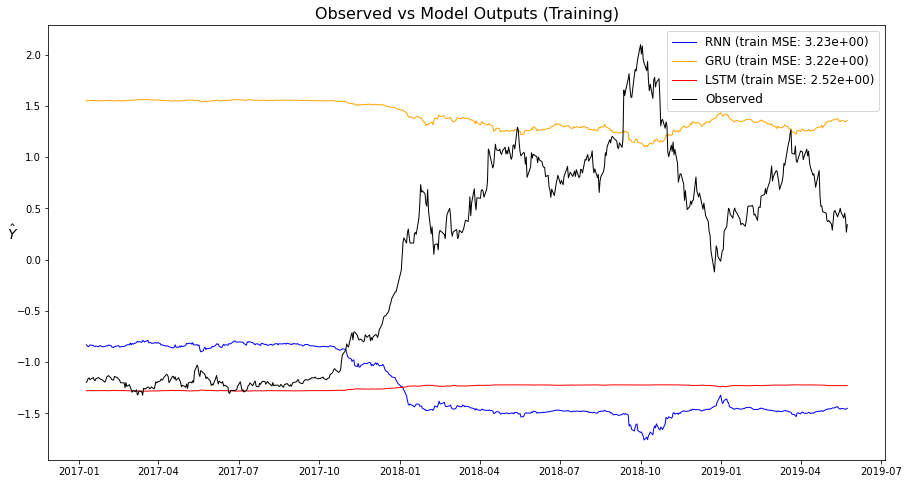

In [ ]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

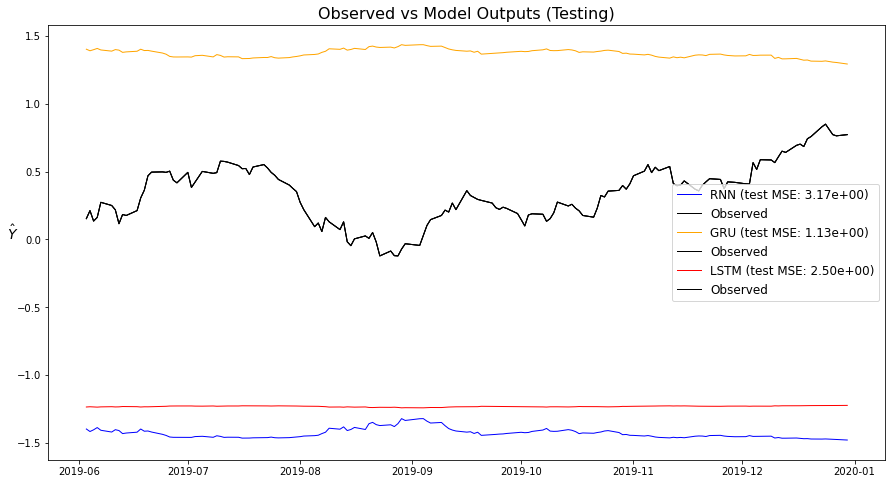

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
    plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

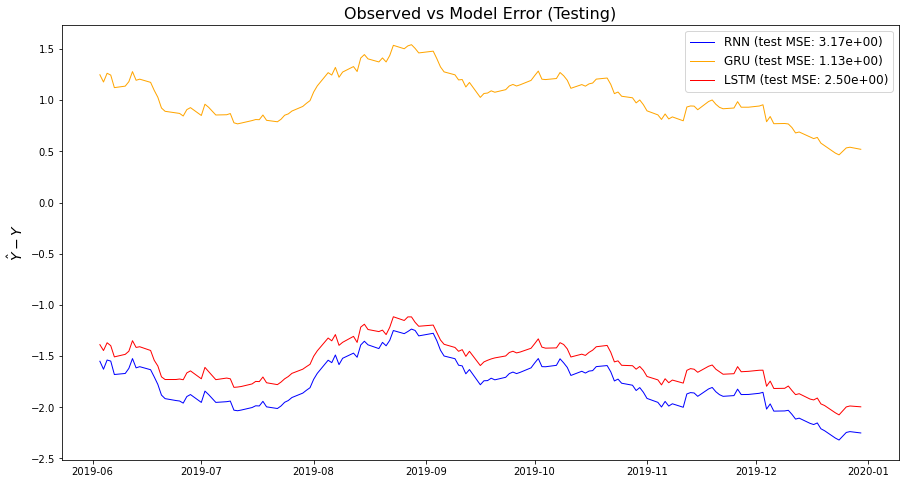

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

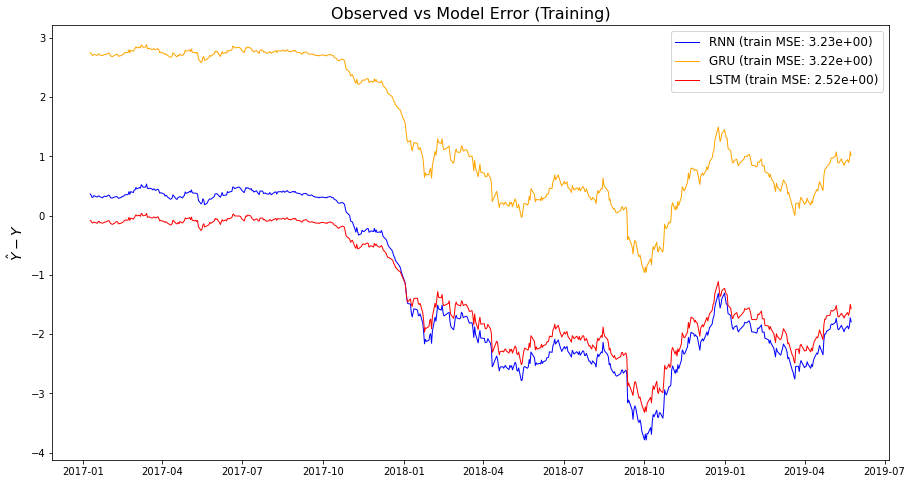

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);